In [1]:
%pylab inline
from sshtunnel import SSHTunnelForwarder
import pymongo
import os
import stat
import json
import datetime
import paramiko
import pandas
import seaborn as sns

pkey=os.path.join(os.environ['HOME'],'.ssh/id_rsa')
key=paramiko.RSAKey.from_private_key_file(pkey)

MONGO_HOST = "129.94.162.112"
MONGO_USER = "goios"
MONGO_DB = "test2"
MONGO_COLLECTION = "ls-remote"
local_port = 26017

# define ssh tunnel
with SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey=key,
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    connection = pymongo.MongoClient('localhost', local_port)
    db = connection[MONGO_DB]
    collection = db[MONGO_COLLECTION]
    
    collection.drop()

    for f in os.listdir('.'):
        collection.insert_one({'name':f, 
                               'time': {'access': datetime.datetime.fromtimestamp(os.stat(f).st_atime), 
                                        'modification': datetime.datetime.fromtimestamp(os.stat(f).st_mtime)},
                               'size':os.stat(f).st_size,
                               'directory':stat.S_ISDIR(os.stat(f).st_mode)})
    #print (db)
    #print(json.dumps(db.list_collection_names(), indent=2))    

    # close ssh tunnel
    connection.close()
    server.stop()

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': 'black',
 'axes.grid': False,
 'axes.axisbelow': 'line',
 'axes.labelcolor': 'black',
 'figure.facecolor': (1, 1, 1, 0),
 'grid.color': '#b0b0b0',
 'grid.linestyle': '-',
 'text.color': 'black',
 'xtick.color': 'black',
 'ytick.color': 'black',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'projecting',
 'patch.edgecolor': 'black',
 'image.cmap': 'viridis',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['DejaVu Sans',
  'Bitstream Vera Sans',
  'Computer Modern Sans Serif',
  'Lucida Grande',
  'Verdana',
  'Geneva',
  'Lucid',
  'Arial',
  'Helvetica',
  'Avant Garde',
  'sans-serif'],
 'patch.force_edgecolor': False,
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

In [3]:
MONGO_DB = "modal-2duct-simulations"
#MONGO_DB = "test2"
MONGO_COLLECTION = "random-runs-1"
MONGO_COLLECTION = "random-runs-var-gamma"
MONGO_COLLECTION = "modal-vt-bore-var-gamma-nlstiff"
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]
        print (db)
        print(json.dumps(connection.list_database_names(),indent=2))
        print(json.dumps(db.list_collection_names(), indent=2))    


Database(MongoClient(host=['localhost:26017'], document_class=dict, tz_aware=False, connect=True), 'modal-2duct-simulations')
[
  "admin",
  "config",
  "local",
  "modal-2duct-simulations",
  "test1",
  "test2"
]
[
  "random-runs-var-gamma",
  "random-runs-1",
  "random-runs-var-gamma-pert-time",
  "modal-vt-bore-var-gamma-nlstiff-bad-analysis",
  "modal-tests",
  "modal-vt-bore-var-gamma-nlstiff"
]


In [4]:
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]
        #collection.drop()
        print(collection.count())
        print(json.dumps(db.command("dbstats"),indent=2))
#         for d in collection.find():
#             err = "Ok"
#             try:
#                 d['simulation']['error']
#                 err='Error in simulation'
#             except KeyError:
#                 pass
#             try:
#                 d['analysis']['error']
#                 err='Error in analysis'
#             except KeyError:
#                 pass
                
#             print(d['_id'],d['simulation']['start'],d['simulation']['end'],err)
        #ll = list(collection.find({'simulation.params.gamma.sustain_val': {'$gt':.4, '$lt':.65}}))
        ll = list(collection.aggregate([ {'$match':{'simulation.params.gamma.sustain_val': {'$gt':.6, '$lt':.7}}}, { "$sample": { "size": 1000 } } ]))
    print(len(ll))

132716
{
  "db": "modal-2duct-simulations",
  "collections": 6,
  "views": 0,
  "objects": 284431,
  "avgObjSize": 3537.002995454082,
  "dataSize": 1006033299.0,
  "storageSize": 584151040.0,
  "numExtents": 0,
  "indexes": 6,
  "indexSize": 5259264.0,
  "fsUsedSize": 27190272000.0,
  "fsTotalSize": 44780494848.0,
  "ok": 1.0
}
1000


In [5]:
import six

def list_dict_items(obj):
    try:
        for k, v in obj.items():
            yield k, v
    except AttributeError:
        if not isinstance(obj, six.string_types):
            for k, v in enumerate(obj):
                yield k, v

def json_flatten(js,root=""):
    try:
        for k,v in list_dict_items(js):
            yield from json_flatten(v,root=root+"/"+str(k))
    except TypeError:
        yield root[1:], js

def json_array_flatten(js):
    for ii, el in enumerate(js):
        yield {k:v for k,v in json_flatten(el)}
    

In [6]:
{k:v for k,v in json_flatten({'a':1,'b':[0,2,{'a':-1,"b":"hello"}]})}

{'a': 1, 'b/0': 0, 'b/1': 2, 'b/2/a': -1}

In [7]:
dfo=pandas.DataFrame(json_array_flatten(ll))
df=dfo

In [8]:
df['gets larger than perturbation'] = df['analysis/hb1_abs_fin'] > df['analysis/hb1_abs_pert']

In [9]:
df['finishes close to max'] = df['analysis/hb1_abs_fin'] > df['analysis/hb1_abs_max']/2

In [10]:
df['trans dur']=df['analysis/t_trans_end']-df['analysis/t_trans_start']

In [11]:
df['starts after pert'] = df['analysis/t_trans_start'] - df['analysis/pert_time'] >-0.002
df['starts after pert'].value_counts()

False    899
True     101
Name: starts after pert, dtype: int64

In [12]:
df.pivot_table(index='finishes close to max', columns='gets larger than perturbation', values='analysis/f0', aggfunc='count')

gets larger than perturbation,False,True
finishes close to max,,
False,1,11
True,403,585


In [13]:
from scipy.optimize import fmin

from functools import partial

def resonance(x,f=100,q=10,a=1):
    omegar=2*pi*f
    s = 1j*x*2*pi
    #fs = (a*omegar*q)**0*s**0/(s**2+s*omegar/q+omegar**2)
    fs = omegar*s/(s**2+s*omegar/q+omegar**2)
    return(np.abs(fs))

def impedance(x, fvec, qvec, avec):
    ret = 0*x
    for f, q, a in zip(fvec,qvec,avec):
        ret += resonance(x, f, q, a)
    return ret

fsrch = lambda x: -impedance(x, fvec, qvec, avec)

def impedance_info(row):
    zbore = partial(resonance,f=row['simulation/params/bore/frequencies/0'],
                              q=row['simulation/params/bore/qs/0'],
                              a=row['simulation/params/bore/amplitudes/0'])
    zvt = partial(resonance,f=row['simulation/params/vocal/frequencies/0'],
                              q=row['simulation/params/vocal/qs/0'],
                              a=row['simulation/params/vocal/amplitudes/0'])
    ztotal = lambda x: zbore(x)+zvt(x)
    zrat = lambda x: zbore(x)/zvt(x)
    zbore_max_f = fmin(lambda x: -zbore(x),row['simulation/params/bore/frequencies/0'],disp=False)[0]
    zbore_max = zbore(row['analysis/f0'])
    zrat_f0 = zrat(row['analysis/f0'])
    return pandas.Series({"zb_max_f":zbore_max_f,"zb_max_val":zbore_max,"zrat_f0":zrat_f0})



In [14]:
row = df.sample().iloc[0]
row['analysis/f0']

270.5808198379132

In [15]:
impedance_info(row)

zb_max_f      286.249996
zb_max_val      8.580932
zrat_f0        11.227416
dtype: float64

In [16]:
dfc=df.apply(impedance_info,axis=1)

In [17]:
df=pandas.concat((dfo,dfc),axis=1)

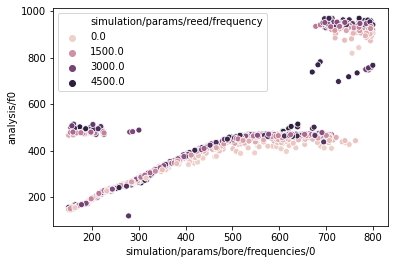

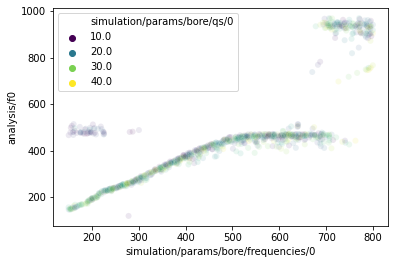

In [18]:
import seaborn as sns
sns.scatterplot(data=df,x='simulation/params/bore/frequencies/0',y='analysis/f0',hue='simulation/params/reed/frequency')
figure()
sns.scatterplot(data=df,x='simulation/params/bore/frequencies/0',y='analysis/f0',hue='simulation/params/bore/qs/0',alpha=.1,palette='viridis')

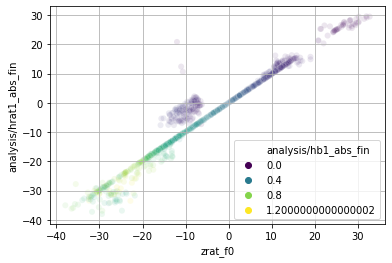

In [19]:
figure()
sns.scatterplot(data=df,x=-20*np.log10(df['zrat_f0']),y='analysis/hrat1_abs_fin',hue='analysis/hb1_abs_fin',alpha=.1,palette='viridis')
grid()

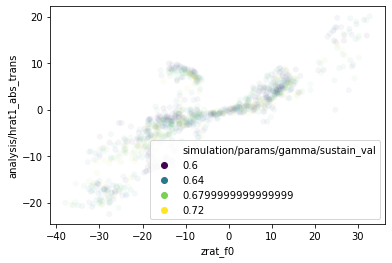

In [20]:
figure()
sns.scatterplot(data=df,x=-20*np.log10(df['zrat_f0']),y='analysis/hrat1_abs_trans',hue='simulation/params/gamma/sustain_val',alpha=.05,palette='viridis')

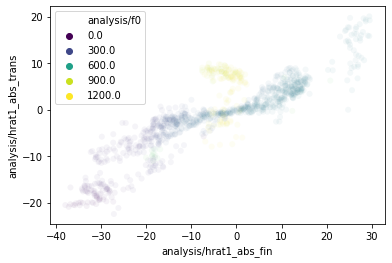

In [21]:
figure()
sns.scatterplot(data=df,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',hue='analysis/f0',alpha=.05,palette='viridis')

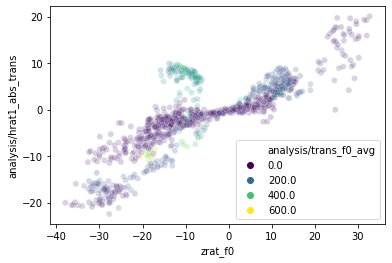

In [22]:
figure()
sns.scatterplot(data=df,x=-20*np.log10(df['zrat_f0']),y='analysis/hrat1_abs_trans',hue='analysis/trans_f0_avg',alpha=.2,palette="viridis")

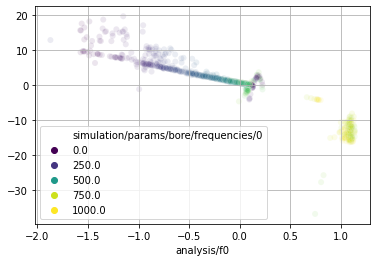

In [23]:
figure()
sns.scatterplot(data=df,y=53.5-20*np.log10(df['zrat_f0'])-df['analysis/hrat1_abs_fin']-20*np.log10(df['analysis/f0']),hue='simulation/params/bore/frequencies/0',x=log2(df['analysis/f0']/440),alpha=.1,palette='viridis')
grid()

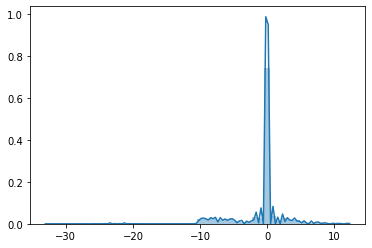

In [24]:
figure()
sns.distplot(-20*np.log10(df['zrat_f0'])-df['analysis/hrat1_abs_fin'])

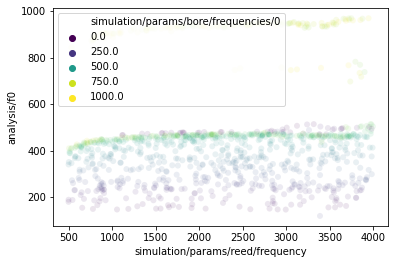

In [25]:
figure()
sns.scatterplot(data=df,x='simulation/params/reed/frequency',y='analysis/f0',hue='simulation/params/bore/frequencies/0',palette='viridis',alpha=.1)

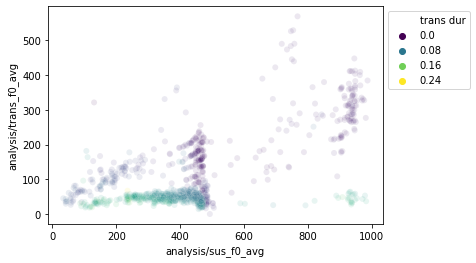

In [26]:
figure()
sns.scatterplot(data=df,x='analysis/sus_f0_avg',y='analysis/trans_f0_avg',hue='trans dur',alpha=0.1,palette='viridis',vmax=0.1)
legend(bbox_to_anchor=(1,1),loc='upper left')

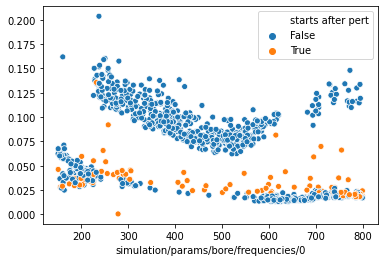

In [27]:
figure()
sns.scatterplot(data=df,x='simulation/params/bore/frequencies/0',y=df['analysis/t_trans_end']-df['analysis/t_trans_start'],hue='starts after pert')

In [28]:
df1 = df[df['starts after pert'] & (df['trans dur']>0.001)]

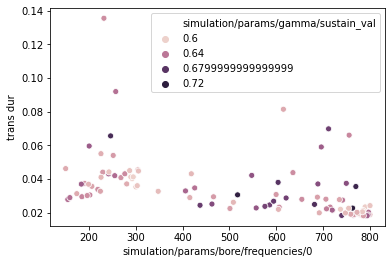

In [29]:
import seaborn as sns
figure()
sns.scatterplot(data=df1,x='simulation/params/bore/frequencies/0',y='trans dur',hue='simulation/params/gamma/sustain_val')

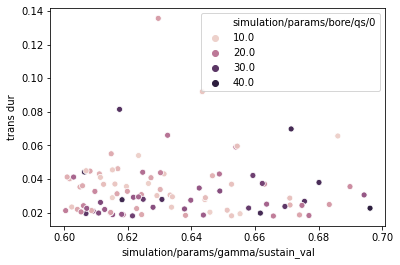

In [30]:
figure()
sns.scatterplot(data=df1,hue='simulation/params/bore/qs/0',y='trans dur',x='simulation/params/gamma/sustain_val')

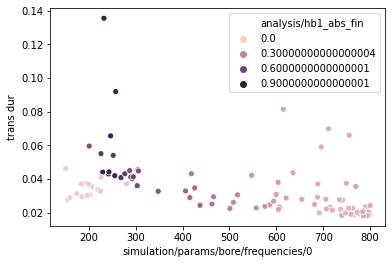

In [31]:
figure()
sns.scatterplot(data=df1,x='simulation/params/bore/frequencies/0',y='trans dur',hue='analysis/hb1_abs_fin')

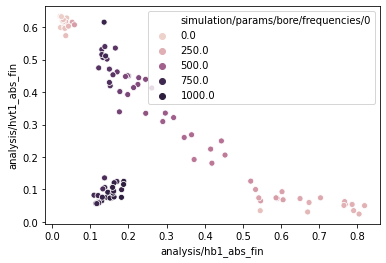

In [32]:
figure()
sns.scatterplot(data=df1,y='analysis/hvt1_abs_fin',x='analysis/hb1_abs_fin',hue='simulation/params/bore/frequencies/0')

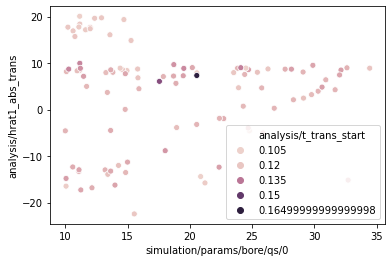

In [33]:
figure()
sns.scatterplot(data=df1,hue='analysis/t_trans_start',y='analysis/hrat1_abs_trans',x='simulation/params/bore/qs/0')

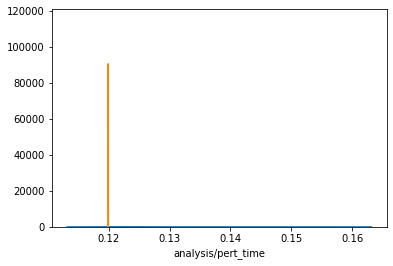

In [34]:
figure()
sns.distplot(df1['analysis/t_trans_start'],norm_hist=False)
sns.distplot(df1['analysis/pert_time'],norm_hist=False)

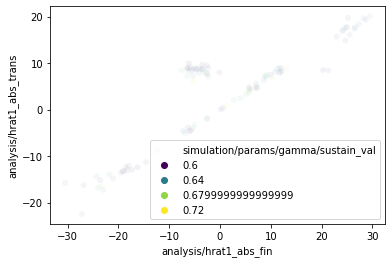

In [35]:
figure()
sns.scatterplot(data=df1,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',hue='simulation/params/gamma/sustain_val',alpha=.05,palette='viridis')

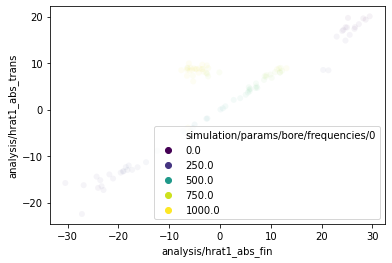

In [36]:
figure()
sns.scatterplot(data=df1,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',
                hue='simulation/params/bore/frequencies/0',palette='viridis',alpha=0.05)

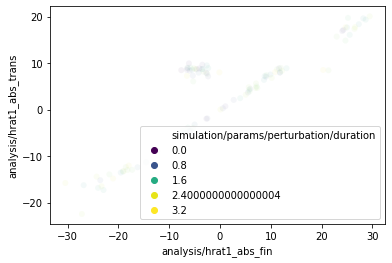

In [37]:
figure()
sns.scatterplot(data=df1,x='analysis/hrat1_abs_fin',y='analysis/hrat1_abs_trans',
                hue='simulation/params/perturbation/duration',palette='viridis',alpha=0.05)

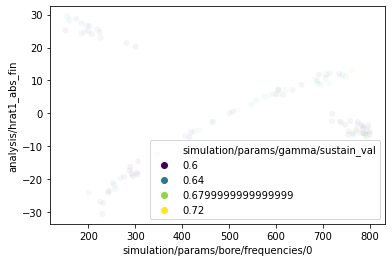

In [38]:
figure()
sns.scatterplot(data=df1,y='analysis/hrat1_abs_fin',hue='simulation/params/gamma/sustain_val',x='simulation/params/bore/frequencies/0',
                palette='viridis',alpha=0.05)

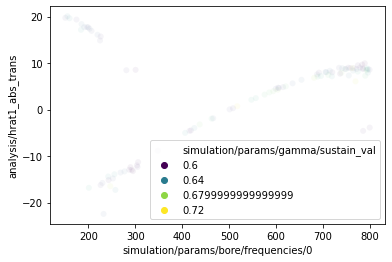

In [39]:
figure()
sns.scatterplot(data=df1,y='analysis/hrat1_abs_trans',hue='simulation/params/gamma/sustain_val',
                x='simulation/params/bore/frequencies/0',
                palette='viridis',alpha=0.05)

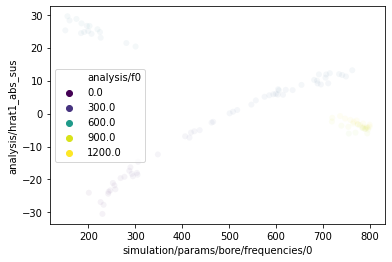

In [40]:
figure()
sns.scatterplot(data=df1,y='analysis/hrat1_abs_sus',hue='analysis/f0',
                x='simulation/params/bore/frequencies/0',
                palette='viridis',alpha=0.05)

In [41]:
{col:len(df[col].unique())for col in df.columns}

{'_id': 1000,
 'simulation/start': 1000,
 'simulation/params/tmax': 1,
 'simulation/params/gamma/sustain_val': 1000,
 'simulation/params/gamma/time_const': 1,
 'simulation/params/gamma/exp_limit_multiplier': 1,
 'simulation/params/zeta': 1,
 'simulation/params/reed/frequency': 1000,
 'simulation/params/reed/q': 1000,
 'simulation/params/reed/amplitude': 1000,
 'simulation/params/bore/frequencies/0': 1000,
 'simulation/params/bore/qs/0': 1000,
 'simulation/params/bore/amplitudes/0': 1000,
 'simulation/params/vocal/frequencies/0': 1,
 'simulation/params/vocal/qs/0': 1,
 'simulation/params/vocal/amplitudes/0': 1,
 'simulation/params/nlfunc/nl_start': 1,
 'simulation/params/nlfunc/nl_ev': 1,
 'simulation/params/perturbation/multiplier': 1,
 'simulation/params/perturbation/duration': 1000,
 'simulation/params/simulation/sample rate': 1000,
 'simulation/end': 1000,
 'analysis/pert_time': 1000,
 'analysis/initial amplitude': 1000,
 'analysis/final amplitude': 1000,
 'analysis/f0': 1000,
 'ana

In [42]:
start = datetime.datetime(2020, 1, 1, 0, 0, 0, 0)
#end = datetime.datetime(2012, 2, 2, 6, 55, 3, 381)

    
with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]

        #for f in os.listdir('.'):
        #    collection.insert_one({'name':f, 'time':os.stat(f).st_mtime, 'size':os.stat(f).st_size})
        for doc in collection.find({'time.modification':{'$gte': start}}):
            print(json.dumps(doc,default=str,indent=2))


In [43]:
from random_single_mode_vt_bore_reed import ivp_simulate, do_analysis

def simulate_js(js):
    data = ivp_simulate(js)
    analysis = do_analysis(data, impedance=False)
 
    return data,analysis

In [148]:
import os
import numpy as np
from glob import glob
from pypevoc.Heterodyne import HeterodyneHarmonic
from pypevoc.PVAnalysis import PV
import timeseries as ts
import scipy.signal as sig

def db(x):
    return 20*np.log10(x)



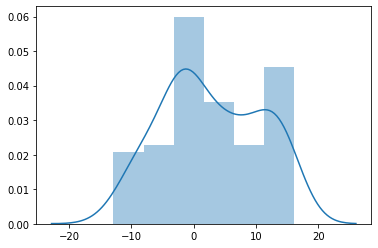

In [45]:
plt.figure()
sns.distplot(df1['analysis/hrat1_abs_trans']-df1['analysis/hrat1_abs_fin'])

In [181]:
import random
from json_object import JSONObject

#row = df[np.abs(-20*np.log10(df['zrat_f0'])-df['analysis/hrat1_abs_fin'])>5].sample().iloc[0]
#row = df[df['analysis/hrat1_abs_fin']<-20].sample().iloc[0]
# row = df1[df1['analysis/hrat1_abs_trans']-df1['analysis/hrat1_abs_fin']<-10].sample().iloc[0]
row = df1.sample().iloc[0]
idx= row.name
print(row['analysis/hrat1_abs_fin'],-20*np.log10(row['zrat_f0']))
data,anal=simulate_js(JSONObject(ll[idx]['simulation']['params']))

28.691534709317235 31.490339630843515


  frat = fx / self.oldfft

  frat = fx / self.oldfft



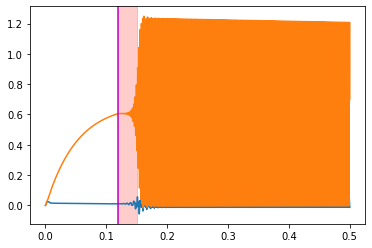

In [182]:
figure()
t = np.arange(len(data['p_b']))/data['js']['simulation']['sample rate']
plot(t,data['p_b'])
plot(t,data['p_vt']+data['p_blow'])
axvline(anal['pert_time'],color='m')
axvspan(anal['t_trans_start'],anal['t_trans_end'],color='r',alpha=.2)

In [183]:
row['analysis/f0']

502.81569573474417

In [184]:
close('all')

In [185]:
t_init=[0.01,0.05]
t_fin=0.1
tsust=0.1

# extract main parameters
res = {}
sr = data['js']['simulation']['sample rate']
pb = data['p_b']
pvt = data['p_vt']
t = np.arange(len(pb))/sr
if data['pert_time']>0:
    res['pert_time']=data['pert_time']
else:
    res['pert_time'] = 0


pbinit = pb[int(t_init[0]*sr):int(t_init[1]*sr)]
res['initial amplitude'] = np.max(pbinit)-np.min(pbinit)
pbfin = pb[-int(t_fin*sr):]
res['final amplitude'] = np.max(pbfin)-np.min(pbfin) 

# fundamental frequency for harmonic analysis
pvpb = PV(pb,sr=sr,progress=False,nfft=1024*16,hop=512*2,pkthresh=1e-10)
pvpb.run_pv()
fts = ts.SampledTimeSeries(pvpb.fundamental_frequency, pvpb.t)

f0 = fts.percentile(50,from_time=fts.t[-1]-0.2)
if f0<20:
    f0 = np.median(fts.v[fts.v>0])
res['f0'] = f0
fw,pbw = sig.welch(pb,nperseg=2**10,nfft=2**12,fs=sr)

mainf = pvpb.f[np.arange(pvpb.f.shape[0]),np.argmin(np.abs(pvpb.f-f0),axis=1)]
mainfts = ts.SampledTimeSeries(mainf, pvpb.t)

# harmonic analysis
try:
    nwind = int(sr/f0*3)
except ValueError:
    nwind = 1024


ha = {}
for lab in ('b', 'vt', 'm'):
    try:
        p = data['p_{}'.format(lab)]
    except KeyError:
        continue

    h = HeterodyneHarmonic(p,sr=sr,tf=[0,max(pvpb.t)],f=[f0,f0],nwind=nwind,nhop=128)
    h_array = [ts.SampledTimeSeries(np.abs(h.camp[:,ii]),h.t,label='h{}{}'.format(lab,ii+1)) for ii in range(h.camp.shape[1])]
    ha[lab] = h_array
    for ii, hts in enumerate(h_array):
        res['{}_t_min'.format(hts.label)]=hts.min_time()
        res['{}_t_max'.format(hts.label)]=hts.max_time()
        res['{}_abs_min'.format(hts.label)]=hts.min()
        res['{}_abs_max'.format(hts.label)]=hts.max()
        res['{}_abs_fin'.format(hts.label)]=hts.v[-1]
        if data['pert_time']>1e-4:
            res['{}_abs_pert'.format(hts.label)]=hts[data['pert_time']]
        else:
            res['{}_abs_pert'.format(hts.label)]=np.nan    

hts_array = ha['b']
vts_array = ha['vt']

# transient detection using one envelope
ats = hts_array[0]

amax = ats.max()

a_trans_end = amax*.7
a_trans_start = amax*.001
try:
    t_trans_end = ats.crossing_times(a_trans_end)[0][0]
except IndexError:
    t_trans_end = ats.v[-1]
try:
    t_trans_start = ats.crossing_times(a_trans_start,to_time=t_trans_end)[0][0]
except IndexError:
    t_trans_start = t_trans_end - ats.dt

atrans, ttrans = ats.apply(db).times_values_in_range(from_time=t_trans_start,to_time=t_trans_end)

# frequency comparison
fsusav = fts.mean(from_time=fts.t[-1]-tsust)
res['t_trans_start']=t_trans_start
res['t_trans_end']=t_trans_end
res['sus_f0_avg']=fts.mean(from_time=fts.t[-1]-tsust)
res['sus_f0_std']=fts.std(from_time=fts.t[-1]-tsust)
res['trans_f0_avg']=fts.mean(from_time=t_trans_start, to_time=t_trans_end)
res['trans_f0_std']=fts.std(from_time=t_trans_start, to_time=t_trans_end)

# harmonic descriptor extraction
for h_array in (hts_array,vts_array):
    for ii, hts in enumerate(h_array):
        res['{}_abs_sus'.format(hts.label)]=hts.percentile(50,from_time=fts.t[-1]-tsust)
        res['{}_abs_sus_var'.format(hts.label)]=np.diff(hts.percentile([75,25],from_time=fts.t[-1]-tsust))[0]
        res['{}_abs_trans'.format(hts.label)]=hts.percentile(50,from_time=t_trans_start, to_time=t_trans_end)
        res['{}_abs_trans_var'.format(hts.label)]=np.diff(hts.percentile([75,25],from_time=t_trans_start, to_time=t_trans_end))[0]

    # growth rate via derivative
    dts = hts.apply(db).diff()
    dts.label = hts.label
    for pct in [25,50,75]:
        res['{}_trans_rate_pct{}'.format(dts.label,pct)]=dts.percentile(pct,from_time=t_trans_start, to_time=t_trans_end)

    res['{}_abs_fin'.format(hts.label)]=hts.v[-1]
    if data['pert_time']>1e-4:
        res['{}_abs_pert'.format(hts.label)]=hts[data['pert_time']]
    else:
        res['{}_abs_pert'.format(hts.label)]=np.nan    

# harmonic ratio descriptors
for ii, hts in enumerate(hts_array):
    vts = vts_array[ii]
    rts = vts.apply(db)-hts.apply(db)
    rts.label = 'hrat{}'.format(ii+1)
    res['{}_abs_sus'.format(rts.label)]=rts.percentile(50,from_time=fts.t[-1]-tsust)
    res['{}_abs_sus_var'.format(rts.label)]=np.diff(rts.percentile([75,25],from_time=fts.t[-1]-tsust))[0]
    res['{}_abs_trans'.format(rts.label)]=rts.percentile(50,from_time=t_trans_start, to_time=t_trans_end)
    res['{}_abs_trans_var'.format(rts.label)]=np.diff(rts.percentile([75,25],from_time=t_trans_start, to_time=t_trans_end))[0]
    res['{}_abs_fin'.format(rts.label)]=rts.v[-1]
    if data['pert_time']>1e-4:
        res['{}_abs_pert'.format(rts.label)]=rts[data['pert_time']]
    else:
        res['{}_abs_pert'.format(rts.label)]=np.nan    



  frat = fx / self.oldfft

  frat = fx / self.oldfft



In [186]:
from pypevoc.Heterodyne import heterodyne

def heterodyne_corr(x,sr,f,maxwind=2**14,nhop=2**10,nper=3,dc_cut=50):
    #c1,_ = heterodyne(x,x,wind=np.hanning(nwind),hop=nhop)
    xx = x.copy()
#     newn = int(len(xx)/sr*dc_cut)
#     x2 = np.concatenate((xx,np.zeros(int((newn+1)*sr/dc_cut))))
#     print(newn,x2.shape)
#     xd = sig.resample(x2,newn)
#     xu = sig.resample(xd,len(x2))[:len(xx)]
#     xx -= xu
    t = np.arange(len(x))/sr
    #npts = len(c1)
    nharm = len(f)
    #camp = np.zeros((npts,nharm),dtype='complex')
    ret = []
    part = np.zeros((len(x),nharm))
    for ii,ff in enumerate(f):
        #nwind = int(min(maxwind,sr/ff*nper))
        if ff==0.:
            nwind=maxwind
        foth = np.delete(f,ii)
        nwind = (sr/np.min(np.abs(foth-ff))*nper)
        print(nwind)
        hetsig = np.exp(1j*2*np.pi*ff*t)
        cc,ih = heterodyne(xx,hetsig,wind=np.hanning(nwind),hop=nhop)
        if ff==0.:
            cc/=2
        th=ih/sr
        ret.append(ts.SampledTimeSeries(cc,th,label='%.2f'%ff))
        hf = np.interp(t,th,cc)
        xp = np.real(np.conjugate(hf)*hetsig)
        xx-=xp
        part[:,ii]=xp
    return ret,xx,part

[   0.          168.900373    482.57249429  965.14498859 1447.71748288
 1954.41860189]
7021.714285714285
7021.714285714285
3780.923076923077
2457.6000000000004
2457.6000000000004
2340.571428571428
7021.714285714285
7021.714285714285
3780.923076923077
2457.6000000000004
2457.6000000000004
2340.571428571428


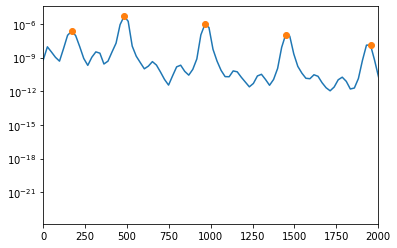

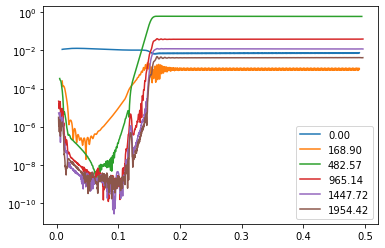

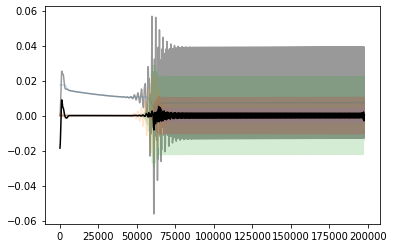

In [224]:
from scipy.signal import welch,find_peaks

fw,w=welch(pb,fs=sr,nperseg=2**14)

fig,ax=subplots(1)
semilogy(fw,w)
xlim(0,2000)

pks,_=find_peaks(10*np.log10(w),prominence=20)
ff=fw[pks]
ff=ff[(ff<2000)&(ff>100)]
nw=int(sr/np.min(ff)*6)
semilogy(fw[pks],w[pks],'o')

ff=np.insert(ff,0,0)

print(ff)

#nw=nwind
nw=2**16
nper=3
hetpb,pbresid,pbpart=heterodyne_corr(pb,sr,ff,maxwind=nw,nhop=128,nper=nper)
hetpv,pvresid,pvpart=heterodyne_corr(pvt,sr,ff,maxwind=nw,nhop=128,nper=nper)
fig,ax=subplots(1)
for tts in hetpv:
    ax.semilogy(tts.t,np.abs(tts.v),label=tts.label)
    
ax.legend()
ax.set_yscale('log')

figure()
plot(pb,color='k',alpha=.4)
plot(pbpart,alpha=.2)
plot(pbresid,color='k')

In [228]:
thr=.05
f0r = f0
for f in ff:
    if f==0:
        continue
    frat = f/f0r
    hno = np.round(frat)
    fdev = np.abs(frat-hno)
    print(f,frat,fdev,fdev<thr,hno)
    #if fdev<thr:
    #    f0r=np.mean([f0r,f/hno])
    

168.90037300290334 0.3478917430001177 0.3478917430001177 False 0.0
482.5724942940095 0.9939764085717648 0.006023591428235164 True 1.0
965.144988588019 1.9879528171435297 0.012047182856470329 True 2.0
1447.7174828820284 2.9819292257152945 0.018070774284705493 True 3.0
1954.4186018907385 4.025604454715648 0.025604454715647762 True 4.0


In [234]:
np.diff(fw)[0]

24.128624714700475

In [230]:
f0r

485.4969294365983

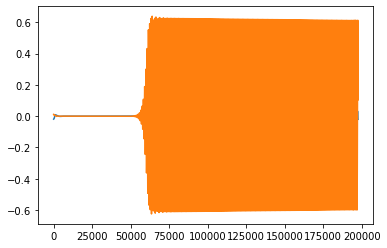

In [197]:
def semilogabsy(x,y,*args,**kwargs):
    return semilogy(x,np.abs(y),*args,**kwargs)
figure()
plot(np.arange(len(pb)),pb-np.sum(pbpart[:,0:2],axis=1))
plot(np.arange(len(pb)),pvt-np.sum(pvpart[:,0:2],axis=1))


485.4969294365983 482.5724942940095


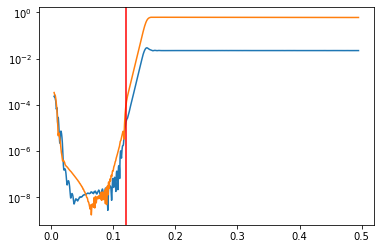

In [198]:
mainidx = np.argmin(np.abs(np.array(ff)-f0))
print( f0,ff[mainidx])
fig,ax=subplots(1)
plot(hetpb[mainidx].t,np.abs(hetpb[mainidx].v))
plot(hetpv[mainidx].t,np.abs(hetpv[mainidx].v))
ax.set_yscale('log')
ax.axvline(data['pert_time'],color='r')

In [199]:
pvt

array([-1.32620566e-05, -3.33450714e-05, -5.63192092e-05, ...,
        1.05992282e-01,  1.01033712e-01,  9.60638859e-02])

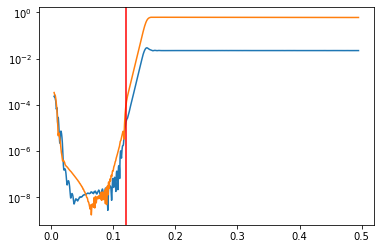

In [200]:
fig,ax=subplots(1)
hb = hetpb[mainidx].apply(np.abs)
hb.plot(ax=ax)
hv = hetpv[mainidx].apply(np.abs)
hv.plot(ax=ax)
ax.axvline(data['pert_time'],color='r')
ax.set_yscale('log')

In [201]:
print(row['analysis/hrat1_abs_trans'],row['analysis/hrat1_abs_fin'],-20*np.log10(row['zrat_f0']))

19.362069136562646 28.691534709317235 31.490339630843515


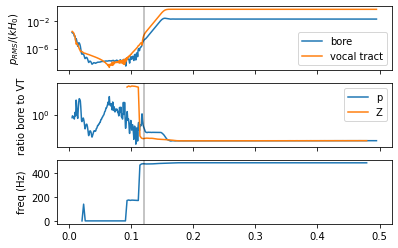

In [202]:

fig,ax = plt.subplots(3,sharex=True)
hb1 = hb.copy()
hb1.label= 'bore'
hb1.plot(ax=ax[0])
hv1 = hv.copy()
hv1.label='vocal tract'
hv1.plot(ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('$p_{RMS}/(k H_0)$')
ax[0].legend()
(hb1/hv1).plot(ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_ylabel('ratio bore to VT')
zts = mainfts.apply(lambda x: impedance(x,fvec = [row['simulation/params/bore/frequencies/0']],
         qvec = [row['simulation/params/bore/qs/0']],
         avec=[row['simulation/params/bore/amplitudes/0']])/impedance(x,fvec = [row['simulation/params/vocal/frequencies/0']],
         qvec = [row['simulation/params/vocal/qs/0']],
         avec=[row['simulation/params/vocal/amplitudes/0']]))
zts.plot(ax=ax[1])
ax[1].legend(['p','Z'])

mainfts.plot(ax=ax[2])
ax[2].set_ylabel('freq (Hz)')

for axi in ax:
    axi.axvline(data['pert_time'],color='k',alpha=.3)

  mag = 20*np.log10(self.mag)



(0.0, 2000.0)

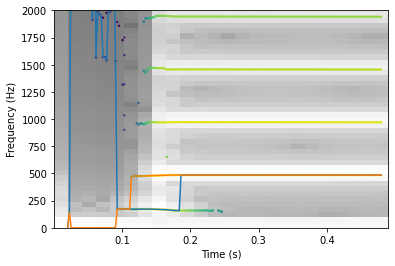

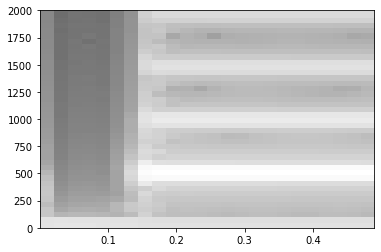

In [203]:
fig,ax = subplots(1)
ax.specgram(data['p_b'],Fs=sr,NFFT=2**13,cmap='gray')
pvpb.plot_time_freq(ax=ax)
ax.plot(pvpb.t,pvpb.fundamental_frequency)
ax.plot(pvpb.t,mainf)
ax.set_ylim(0,2000)
fig,ax = subplots(1)
ax.specgram(data['p_vt'],Fs=sr,NFFT=2**13,cmap='gray')
#pvpb.plot_time_freq(ax=ax)
# ax.plot(pvpb.t,pvpb.fundamental_frequency)
# ax.plot(pvpb.t,mainf)
ax.set_ylim(0,2000)

bore
0.12944013128214088 0.14750237074641354
-364.5200672117976 [2216.52449443]
27.233147759579282
vocal tract
0.1329865512470237 0.15156641328851045
-341.6415476684331 [2192.55766725]
25.02582744768388


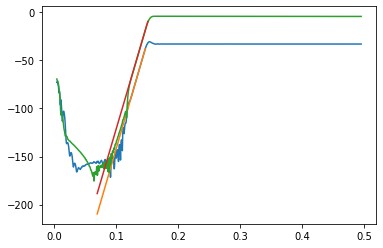

In [204]:
from sklearn.linear_model import RANSACRegressor
fig,ax=subplots(1)
for hh in [hb1,hv1]:
    print(hh.label)
    hbl1=hh.apply(db)
    vals=hbl1.percentile([5,99])
    ted=hbl1.crossing_times(vals[1]-6)[0][0]
    tst=hbl1.crossing_times(vals[1]-46,to_time=ted)[0][-1]
    print(tst,ted)
    x,y=hbl1.times_values_in_range(tst,ted)
    X = np.array([x]).T
    rm=RANSACRegressor().fit(X,y)
    print(rm.estimator_.intercept_,rm.estimator_.coef_)
    fig,ax=hbl1.plot(ax=ax)
    xpred,ytrue = hbl1.times_values_in_range(data['pert_time']-.05,ted)
    Xpred = np.array([xpred]).T
    ypred = rm.predict(Xpred)
    ax.plot(xpred,ypred)
    print (np.max(ypred-ytrue))

In [125]:
y

array([-62.26083515, -61.61742593, -60.97632283, -60.35847936,
       -59.74546273, -59.12229561, -58.50769207, -57.92342712,
       -57.34906529, -56.74883767, -56.13431409, -55.53463914,
       -54.93124474, -54.29529259, -53.64761857, -53.02183933,
       -52.4142458 , -51.8029421 , -51.18976174, -50.60072993,
       -50.03686255, -49.45696345, -48.84476777, -48.23316146,
       -47.62762877, -46.99337391, -46.33063037, -45.67805276,
       -45.05190145, -44.43629875, -43.81791665, -43.21253568,
       -42.64011955, -42.07425849, -41.47476717, -40.8576783 ,
       -40.25149616, -39.63439611, -38.98906714, -38.34667173,
       -37.73696017, -37.1559536 , -36.58448532, -36.01947285,
       -35.48171564, -34.96354117, -34.40818139, -33.80008882,
       -33.17918829, -32.54317628, -31.85693336, -31.13543079,
       -30.42256861, -29.73680475, -29.06774082, -28.39710621,
       -27.73914449, -27.1181955 , -26.50953403, -25.8776424 ,
       -25.24244237, -24.63247561, -24.04255173, -23.47

In [95]:
row.to_dict()

{'_id': ObjectId('5f8a7fd96d0215526df31df2'),
 'simulation/start': Timestamp('2020-10-17 16:23:15.952000'),
 'simulation/params/tmax': 0.5,
 'simulation/params/gamma/sustain_val': 0.60499374345952,
 'simulation/params/gamma/time_const': 0.05,
 'simulation/params/gamma/exp_limit_multiplier': 1.1,
 'simulation/params/zeta': 0.5,
 'simulation/params/reed/frequency': 3262.328890288448,
 'simulation/params/reed/q': 2.526013384920147,
 'simulation/params/reed/amplitude': 2.526013384920147,
 'simulation/params/bore/frequencies/0': 300.4488877946501,
 'simulation/params/bore/qs/0': 13.654829254145348,
 'simulation/params/bore/amplitudes/0': 13.654829254145348,
 'simulation/params/vocal/frequencies/0': 500,
 'simulation/params/vocal/qs/0': 15,
 'simulation/params/vocal/amplitudes/0': 15,
 'simulation/params/nlfunc/nl_start': 0.75,
 'simulation/params/nlfunc/nl_ev': 1.1,
 'simulation/params/perturbation/multiplier': 1.1,
 'simulation/params/perturbation/duration': 2.4860966879172275,
 'simulatio

In [62]:
ll[idx]['simulation']['params']

{'description': 'Reed simulation with modal tracts and reed dynamics and non-linear reed force var gamma',
 'version': '20201006',
 'db': 'modal-vt-bore-var-gamma-nlstiff',
 'tmax': 0.5,
 'gamma': {'sustain_val': 0.60499374345952,
  'time_const': 0.05,
  'exp_limit_multiplier': 1.1},
 'zeta': 0.5,
 'reed': {'frequency': 3262.328890288448,
  'q': 2.526013384920147,
  'amplitude': 2.526013384920147},
 'bore': {'frequencies': [300.4488877946501],
  'qs': [13.654829254145348],
  'amplitudes': [13.654829254145348]},
 'vocal': {'frequencies': [500], 'qs': [15], 'amplitudes': [15]},
 'nlfunc': {'type': 'parabolic', 'nl_start': 0.75, 'nl_ev': 1.1},
 'perturbation': {'multiplier': 1.1, 'duration': 2.4860966879172275},
 'simulation': {'sample rate': 326232.8890288448}}

In [63]:
df1

,_id,simulation/start,simulation/params/tmax,simulation/params/gamma/sustain_val,simulation/params/gamma/time_const,simulation/params/gamma/exp_limit_multiplier,simulation/params/zeta,simulation/params/reed/frequency,simulation/params/reed/q,simulation/params/reed/amplitude,...,analysis/hrat4_abs_trans_var,analysis/hrat4_abs_fin,analysis/hrat4_abs_pert,gets larger than perturbation,finishes close to max,trans dur,starts after pert,zb_max_f,zb_max_val,zrat_f0
2,5f8d1e5c2cacf5a9ccc074f8,2020-10-19 16:04:17.444,0.5,0.638163,0.05,1.1,0.5,1103.881092,3.595713,3.595713,...,-5.001590,-2.513549,-2.258564,True,True,0.018399,True,764.377597,2.818348,3.578966
19,5f89f3408f39e8a5e1185d7f,2020-10-17 06:23:35.474,0.5,0.676957,0.05,1.1,0.5,783.457883,4.959153,4.959153,...,-4.557908,-4.094861,8.759885,True,True,0.018299,True,739.358082,2.919604,3.448348
33,5f899d8da7d7882bc5fce214,2020-10-17 00:17:59.487,0.5,0.659345,0.05,1.1,0.5,510.777057,2.502157,2.502157,...,-2.386615,-0.984845,1.382423,True,True,0.042134,True,547.404556,1.456501,0.729946
46,5f8ac659338d42d4a3b2fa28,2020-10-17 21:24:17.936,0.5,0.624707,0.05,1.1,0.5,820.128298,4.783524,4.783524,...,-21.879490,9.406581,5.787946,True,True,0.044043,True,229.739987,19.261990,33.649995
57,5f88f52b7f323df3449b66a4,2020-10-16 12:19:32.195,0.5,0.615162,0.05,1.1,0.5,718.099507,2.409848,2.409848,...,-3.238297,1.975873,0.058476,True,True,0.028908,True,415.406133,3.620069,2.321717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,5f8cf15a199f2227983ae5be,2020-10-19 12:52:20.411,0.5,0.648941,0.05,1.1,0.5,500.542050,4.185167,4.185167,...,-3.916503,2.255815,3.846884,True,True,0.032876,True,406.145635,2.832856,2.228069
961,5f88caf18f39e8a5e1184087,2020-10-16 09:19:18.144,0.5,0.621500,0.05,1.1,0.5,1088.448769,4.015023,4.015023,...,-7.247021,-4.327023,7.153531,True,True,0.018083,True,785.556331,3.469605,4.377266
971,5f8cf91c338d42d4a3b331b0,2020-10-19 13:25:15.552,0.5,0.644405,0.05,1.1,0.5,2247.251663,0.508863,0.508863,...,-13.161618,10.498328,4.693595,True,True,0.028899,True,159.575651,0.373036,0.038646
976,5f8cae80a7d7882bc5fd30c0,2020-10-19 08:07:02.416,0.5,0.605341,0.05,1.1,0.5,972.997735,1.295775,1.295775,...,-6.352538,-4.834731,2.328266,True,True,0.020449,True,783.626704,3.703470,4.558795


In [64]:
dfo.loc[idx]

_id                                      5f8a7fd96d0215526df31df2
simulation/start                       2020-10-17 16:23:15.952000
simulation/params/tmax                                        0.5
simulation/params/gamma/sustain_val                      0.604994
simulation/params/gamma/time_const                           0.05
                                                  ...            
analysis/hrat4_abs_pert                                   5.04923
gets larger than perturbation                                True
finishes close to max                                       False
trans dur                                               0.0352793
starts after pert                                            True
Name: 704, Length: 146, dtype: object

In [65]:
ll[idx]

{'_id': ObjectId('5f8a7fd96d0215526df31df2'),
 'simulation': {'start': datetime.datetime(2020, 10, 17, 16, 23, 15, 952000),
  'params': {'description': 'Reed simulation with modal tracts and reed dynamics and non-linear reed force var gamma',
   'version': '20201006',
   'db': 'modal-vt-bore-var-gamma-nlstiff',
   'tmax': 0.5,
   'gamma': {'sustain_val': 0.60499374345952,
    'time_const': 0.05,
    'exp_limit_multiplier': 1.1},
   'zeta': 0.5,
   'reed': {'frequency': 3262.328890288448,
    'q': 2.526013384920147,
    'amplitude': 2.526013384920147},
   'bore': {'frequencies': [300.4488877946501],
    'qs': [13.654829254145348],
    'amplitudes': [13.654829254145348]},
   'vocal': {'frequencies': [500], 'qs': [15], 'amplitudes': [15]},
   'nlfunc': {'type': 'parabolic', 'nl_start': 0.75, 'nl_ev': 1.1},
   'perturbation': {'multiplier': 1.1, 'duration': 2.4860966879172275},
   'simulation': {'sample rate': 326232.8890288448}},
  'end': datetime.datetime(2020, 10, 17, 16, 23, 36, 892000

In [66]:
row.name

704

In [67]:
idx

704

In [68]:
df1.loc[idx]

_id                                      5f8a7fd96d0215526df31df2
simulation/start                       2020-10-17 16:23:15.952000
simulation/params/tmax                                        0.5
simulation/params/gamma/sustain_val                      0.604994
simulation/params/gamma/time_const                           0.05
                                                  ...            
trans dur                                               0.0352793
starts after pert                                            True
zb_max_f                                                  300.449
zb_max_val                                               0.984158
zrat_f0                                                 0.0787333
Name: 704, Length: 149, dtype: object